In [1]:
import numpy as np
import netCDF4 as nc
import glob
import os

import matplotlib as mpl
font = {'family' : 'sans',
        'size'   : 12}

mpl.rc('font', **font)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator, LogLocator, MaxNLocator, FormatStrFormatter
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt

import pandas as pd
from cmcrameri import cm


In [2]:
from proteus.utils.plot import latexify
import utils.load_grid as lg

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# %matplotlib widget

In [4]:
def load_grid(pgrid_dir):
    cases = lg.get_cases(pgrid_dir)
    ncases = len(cases)

    # Helpfiles
    helps, hvars = lg.load_helpfiles(cases)

    # Case numbers
    cnums = ["%d"%int(s.split("_")[-1]) for s in cases]

    # Statuses
    statuses = lg.get_statuses(pgrid_dir)

    conf = []
    for f in cases:
        conf.append( lg.read_config(f) )

    out = {
        "status": statuses,
        "cnums": cnums,
        "helps": helps,
        "hvars": hvars,
        "ncases": ncases,
        "dir": pgrid_dir,
        "conf": conf,
    }

    return out

In [5]:
ecc_b = load_grid("data/output/ECC_b2/")
ecc_c = load_grid("data/output/ECC_c2/")
ecc_d = load_grid("data/output/ECC_d2/")

Helpfiles:   0%|          | 0/12 [00:00<?, ?it/s]

Helpfiles: 100%|██████████| 12/12 [00:00<00:00, 12.78it/s]


[0.001      0.00161877 0.00262041 0.00424183 0.00686654 0.01111534
 0.01799315 0.02912674 0.04714942 0.07632396 0.12355077 0.2       ]


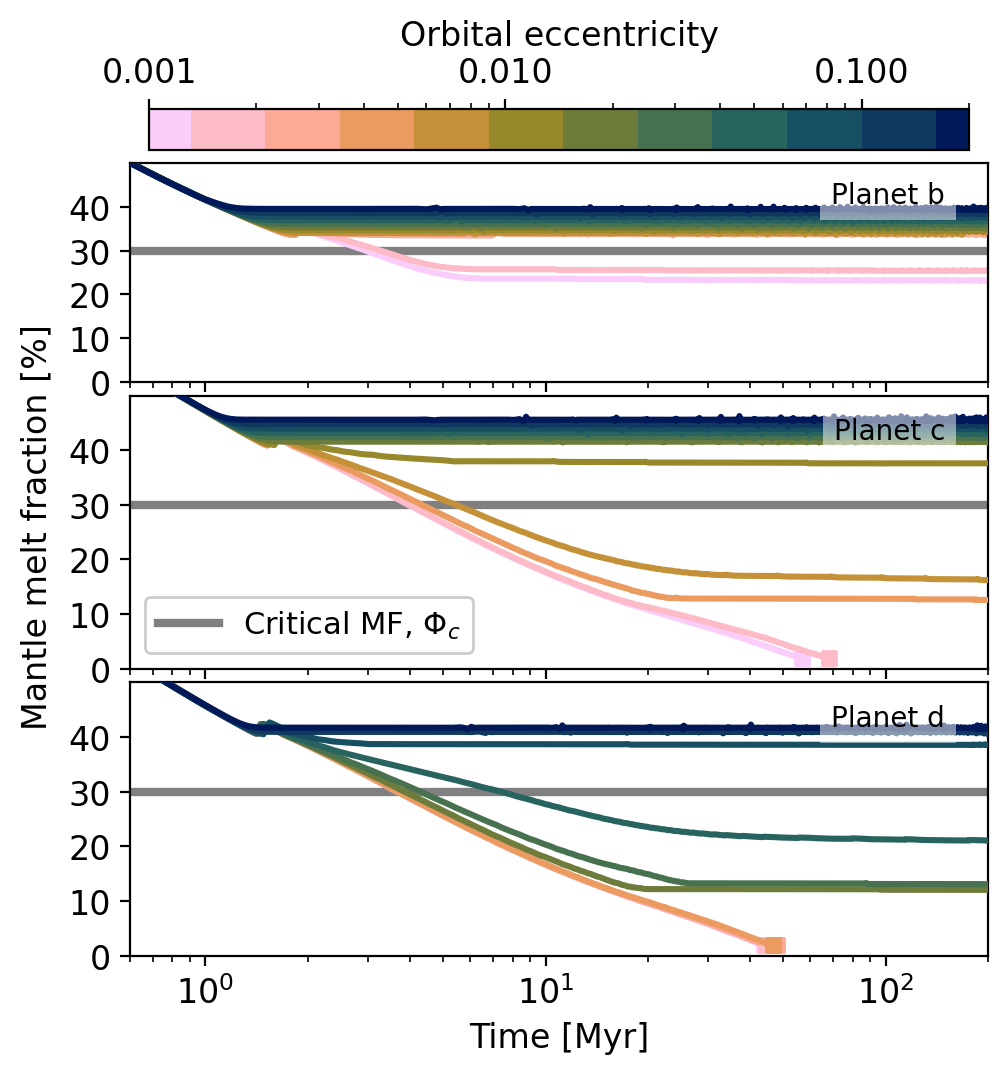

In [10]:
fs = 1.1
fig,axs = plt.subplots(3,1, figsize=(5*fs,5*fs), sharex=True)

lw = 2.2
xmin=0.6
xmax=200
cmap = cm.batlow_r

# get all z's
z_uni = []
z_key = "orbit.eccentricity"
z_lbl = "Orbital eccentricity"
for i in range(ecc_b["ncases"]):
    z_uni.append(lg.descend_get(ecc_b["conf"][i],z_key))
z_uni = np.unique(z_uni)
print(z_uni)
z_min = np.amin(z_uni)
z_max = np.amax(z_uni)

norm = mpl.colors.LogNorm(vmin=z_min, vmax=z_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

lbls = ("Planet b", "Planet c", "Planet d")
for i,pl in enumerate((ecc_b, ecc_c, ecc_d)):
    axt = axs[i].text(0.95, 0.92, lbls[i], zorder=99,
                horizontalalignment='right', verticalalignment='top', transform=axs[i].transAxes, fontsize=10)
    axt.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

    for j in range(pl["ncases"]):

        if not pl["status"][j] in (10,13):
            continue

        hf = pl["helps"][j]
        x = hf["Time"][:] / 1e6

        i0 = np.argmin(np.abs(x-xmin))
        x = np.array(x[i0:])
        y = np.array(hf["Phi_global"][i0:]) * 100

        e = float(hf["eccentricity"].iloc[0])
        c = sm.to_rgba(e)

        if y[-1] < 2.5:
            axs[i].scatter(x[-1],y[-1], color=c, s=25, marker='s', zorder=j)
        axs[i].plot(x,y, c=c, lw=lw, zorder=j)


for ax in axs:
    ax.set_ylim(bottom=0, top=50)
    ax.axhline(30, ls='solid', lw=3, color='grey', zorder=-2, label=r"Critical MF, $\Phi_c$")
    ax.set_yticks(np.arange(0,50,10))
fig.supylabel("Mantle melt fraction [%]", fontsize=12)

axs[-1].set_xlim(left=xmin, right=xmax)
axs[-1].set_xscale("log")
axs[-1].set_xlabel("Time [Myr]")

axs[1].legend(loc='lower left', framealpha=1, fontsize=11)

cbar = fig.colorbar(sm, ax=axs[0], orientation='horizontal', values=z_uni, location='top')
cbar.set_label(z_lbl)
cbar.ax.xaxis.set_major_formatter(FormatStrFormatter("%.3f"))
cbar.ax.set_xlim(left=z_min, right=z_max)

fig.subplots_adjust(hspace=0.05, left=0.12)
plt.show()
fig.savefig("output/eccentricity.pdf", bbox_inches='tight')